### **Getting data**

In [1]:
from data.data_loader import get_data
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
seed = 0
train_tensor, validation_tensor, test_tensor = get_data(seed=seed)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = train_tensor.cache().shuffle(961).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_tensor.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_tensor.cache().prefetch(buffer_size=AUTOTUNE)

### **Model training**

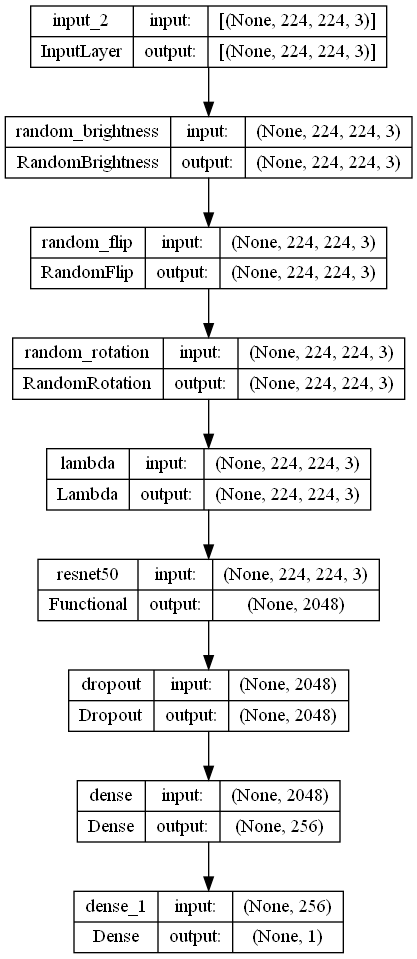

In [5]:
from resnet import ResNet

model = ResNet()
tf.keras.utils.plot_model(model.model, to_file='./raw_models/resnet_topology.png', show_shapes=True)

In [6]:
model.model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0  

In [7]:
model.fit(
    training_data,
    validation_data,
    learning_rate=0.01,
    patience=5,
    epochs=100,
    verbose=1
)

Epoch 1/100
36/36 [==============================] - 107s 3s/step - loss: 2.3720 - roc_auc: 0.6464 - binary_accuracy: 0.6495 - val_loss: 0.5846 - val_roc_auc: 0.8671 - val_binary_accuracy: 0.6767 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 104s 3s/step - loss: 0.4178 - roc_auc: 0.8926 - binary_accuracy: 0.8167 - val_loss: 0.4713 - val_roc_auc: 0.8840 - val_binary_accuracy: 0.7764 - lr: 0.0100
Epoch 3/100
36/36 [==============================] - 104s 3s/step - loss: 0.3666 - roc_auc: 0.9136 - binary_accuracy: 0.8409 - val_loss: 0.4393 - val_roc_auc: 0.9080 - val_binary_accuracy: 0.8338 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - 106s 3s/step - loss: 0.3454 - roc_auc: 0.9255 - binary_accuracy: 0.8570 - val_loss: 0.3566 - val_roc_auc: 0.9266 - val_binary_accuracy: 0.8640 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - 107s 3s/step - loss: 0.3162 - roc_auc: 0.9364 - binary_accuracy: 0.8701 - val_loss: 0.3450 - val_roc_auc: 0.931

In [8]:
model.save_model('resnet')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\functional
......vars
...layers\functional\layers\activation
......vars
...layers\functional\layers\activation_1
......vars
...layers\functional\layers\activation_10
......vars
...layers\functional\layers\activation_11
......vars
...layers\functional\layers\activation_12
......vars
...layers\functional\layers\activation_13
......vars
...layers\functional\layers\activation_14
......vars
...layers\functional\layers\activation_15
......vars
...layers\functional\layers\activation_16
......vars
...layers\functional\layers\activation_17
......vars
...layers\functional\layers\activation_18
......vars
...layers\functional\layers\activation_19
......vars
...layers\functional\layers\activation_2
......vars
...layers\functional\layers\activation_20
......vars
...layers\functional\layers\activati

### **Model evaluation**

In [9]:
y_true, y_pred = model.predict(test_data)

In [10]:
import numpy as np

y_probas = np.column_stack((1 - y_pred, y_pred))

In [11]:
from plots import plot_target_vs_score

In [12]:
plot_target_vs_score(y_true, y_pred, quantiles=10)

In [13]:
plot_target_vs_score(y_true, y_pred, quantiles=100, lower_limit=90)

In [14]:
loss, auc, accuracy = model.evaluate(test_data, verbose=1)
loss, auc, accuracy

42/42 [==============================] - 80s 2s/step - loss: 0.4325 - roc_auc: 0.9148 - binary_accuracy: 0.8341


(0.43254944682121277, 0.9147813320159912, 0.8340573310852051)

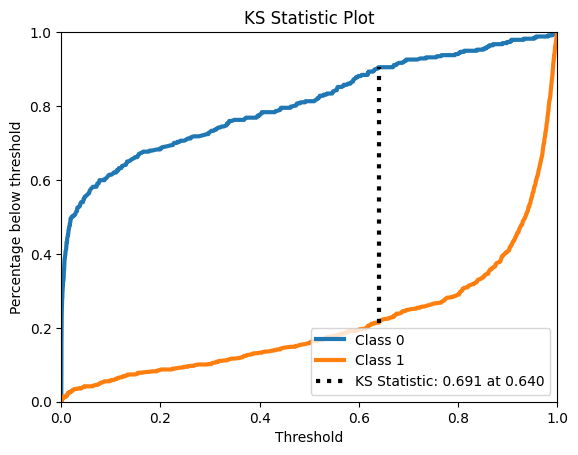

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_ks_statistic(y_true=y_true, y_probas=y_probas)
plt.show()

In [16]:
from sklearn import metrics

results = [(labels, model.model.predict(images).reshape(-1)) for images, labels in test_data.take(-1)]

1/1 [==============================] - 0s 291ms/step


##### Other metrics

In [17]:
labels = np.concatenate([x[0] for x in results])
preds = np.concatenate([x[1] for x in results])

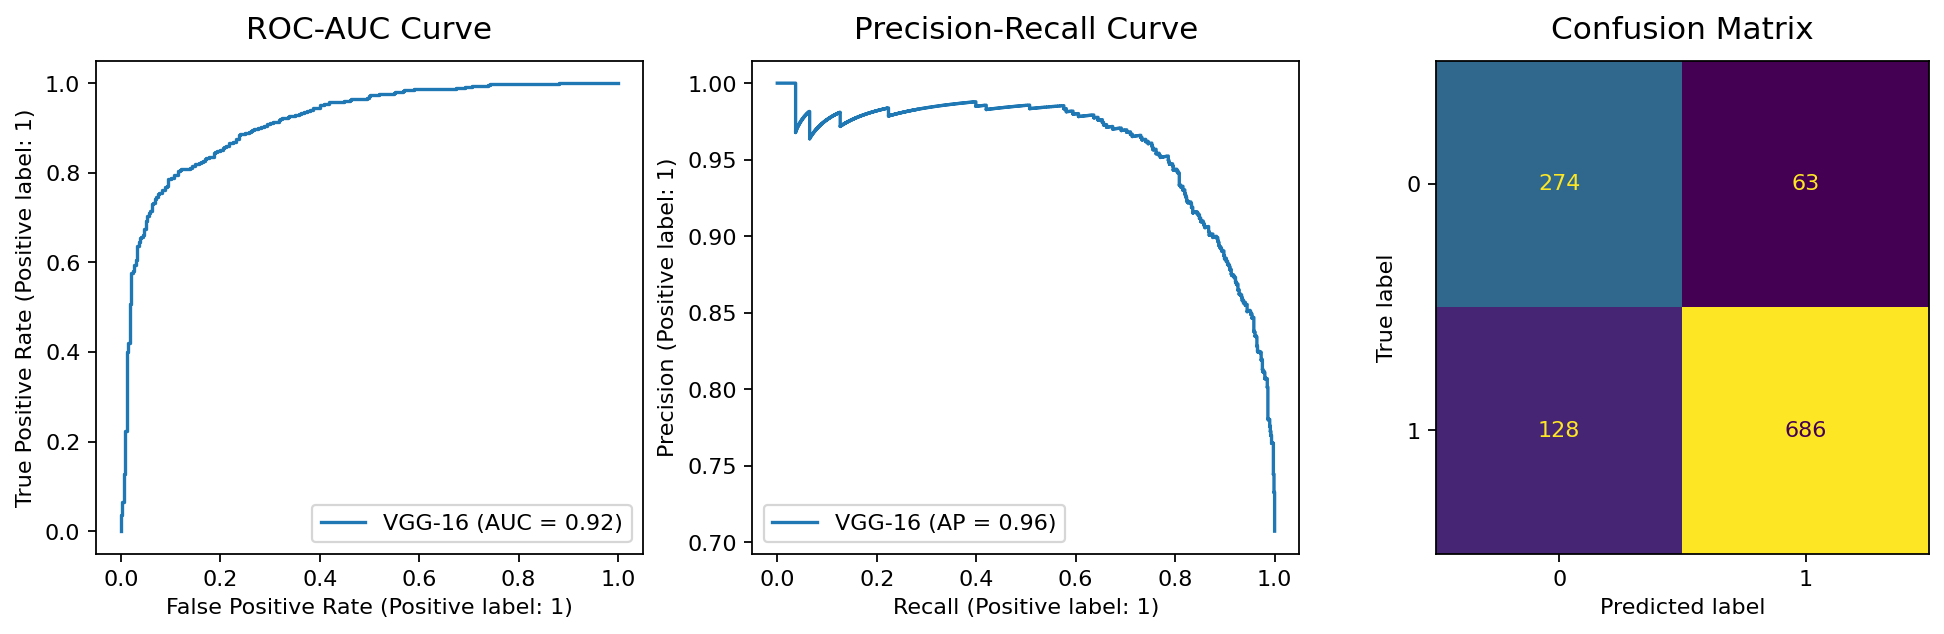

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
for ax, curve in zip(axes[:2], curves):
    curve.from_predictions(labels, preds, ax=ax, name='VGG-16')
metrics.ConfusionMatrixDisplay.from_predictions(
    labels, preds.round().astype('uint8'), ax=axes[2], colorbar=False,
)
titles = ['ROC-AUC Curve', 'Precision-Recall Curve', 'Confusion Matrix']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, size=14, pad=10)